In [88]:
"""
2D Navier-Stokes Equation (vorticity-streamfunction formulation)
    Spatial: CDS and Arakawa scheme
    Temporal: RK3
"""
import sys
import numpy as np
import scipy
from numba import njit, jit, float64, int64
import pyfftw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import scipy.sparse
import numpy.linalg
from tqdm.notebook import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)

%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 1200
matplotlib.rcParams['savefig.dpi'] = 1200
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


In [89]:
@njit(float64(float64[:, :]))
def rms(a):
    return np.sqrt(np.mean(a**2))


In [90]:
def BoundaryConditionDir(w, s, dX, dY):
    s[0, :] = 0
    s[-1, :] = 0
    s[:, 0] = 0
    s[:, -1] = 0

    w[0, :] = (-4*s[1, :] + 0.5*s[2, :])/dX**2
    w[-1, :] = (-4*s[-2, :] + 0.5*s[-3, :])/dX**2

    w[:, 0] = (-4*s[:, 1] + 0.5*s[:, 2])/dY**2
    # Modified from -3 to +3 to match the verification exercise
    w[:, -1] = (-4*s[:, -2] + 0.5*s[:, -3])/dY**2 + 3/dY


In [91]:
def rhs(omega, psi, dX, dY, Re): # checked
    result = psi*0
    viscousContribution = 1/Re*(
        (omega[0:-2, 1:-1]+omega[2:, 1:-1] - 2*omega[1:-1, 1:-1])/dX**2 +
        (omega[1:-1, 0:-2]+omega[1:-1, 2:] - 2*omega[1:-1, 1:-1])/dY**2
    )

    J1 = (
        (omega[2:, 1:-1]-omega[0:-2, 1:-1])*(psi[1:-1, 2:]-psi[1:-1, 0:-2]) -
        (omega[1:-1, 2:]-omega[1:-1, 0:-2])*(psi[2:, 1:-1]-psi[0:-2, 1:-1])
    )

    J2 = (
        omega[2:, 1:-1]*(psi[2:, 2:] - psi[2:, :-2]) -
        omega[:-2, 1:-1]*(psi[:-2, 2:] - psi[:-2, :-2]) -
        omega[1:-1, 2:]*(psi[2:, 2:] - psi[:-2, 2:]) +
        omega[1:-1, :-2]*(psi[2:, :-2]-psi[:-2, :-2])
    )

    J3 = (
        omega[2:, 2:]*(psi[1:-1, 2:] - psi[2:, 1:-1]) -
        omega[:-2, :-2]*(psi[:-2, 1:-1] - psi[1:-1, :-2]) -
        omega[:-2, 2:]*(psi[1:-1, 2:] - psi[:-2, 1:-1]) +
        omega[2:, :-2]*(psi[2:, 1:-1] - psi[1:-1, :-2])
    )

    result[1:-1, 1:-1] = viscousContribution - (J1+J2+J3)/(12*dX*dY)

    return result


In [92]:
def PoissonFSTCentralDiff(fA, dX, dY, mA, nA, Nx, Ny): # checked
    eps = 1e-10
    f = fA[1:-1,1:-1]
    m = mA[1:-1,1:-1] # important to plus 1
    n = nA[1:-1,1:-1]
    fTilda = pyfftw.interfaces.scipy_fftpack.dstn(f)
    u = fA*0
    uTilda = fTilda/(2/dX**2*np.cos(np.pi*m/Nx) + 2/dY**2*np.cos(np.pi*n/Ny)-2/dX**2-2/dY**2+eps)
    u[1:-1,1:-1] = np.real(pyfftw.interfaces.scipy_fftpack.idstn(uTilda))/(4*(Nx-1)*(Ny-1))
    return u


In [93]:
def PoissonpyFFTWFSTCentralDiff(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[1:-1,1:-1]*1
    m = mA[1:-1,1:-1] # important to plus 1
    n = nA[1:-1,1:-1]

    fTilda = f*0
    fstOBJ = pyfftw.FFTW(f,fTilda, axes=(0,1),direction=("FFTW_RODFT00",'FFTW_RODFT00')) # there are some problems within scipy dst package
    fstOBJ()
    uTilda = fTilda/(2/dX**2*np.cos(np.pi*m/Nx) + 2/dY**2*np.cos(np.pi*n/Ny)-2/dX**2-2/dY**2+eps)

    ut = fTilda*0
    ifstOBJ = pyfftw.FFTW(uTilda,ut, axes=(0,1),direction=("FFTW_RODFT00",'FFTW_RODFT00'))
    ifstOBJ()
    u = fA*0
    u[1:-1,1:-1] = ut/(4*(Nx)*(Ny))
    return u


In [94]:
def RK3NavierStokes(wOrig, sOrig, dX, dY, mA, nA, Nx, Ny, dT, Re, BCFun):
    wOne = wOrig*0
    wTwo = wOrig*0
    wNow = wOrig*0
    # First Intermediate
    wOne = wOrig + dT * rhs(wOrig, sOrig, dX, dY, Re)
    sOne = PoissonpyFFTWFSTCentralDiff(-wOne, dX, dY, mA, nA, Nx, Ny)
    BCFun(wOne, sOne, dX, dY)

    # Second Intermediate
    wTwo = 0.75*wOrig + 0.25*wOne + 0.25 * dT * rhs(wOne, sOne, dX, dY, Re)
    sTwo = PoissonpyFFTWFSTCentralDiff(-wTwo, dX, dY, mA, nA, Nx, Ny)
    BCFun(wTwo, sTwo, dX, dY)

    # Second Intermediate
    wNow = 1/3*wOrig + 2/3*wTwo + 2/3 * dT * rhs(wTwo, sTwo, dX, dY, Re)
    sNow = PoissonpyFFTWFSTCentralDiff(-wNow, dX, dY, mA, nA, Nx, Ny)
    BCFun(wNow, sNow, dX, dY)

    temporalSpeed = rms(wOrig-wNow)/dT

    return wNow, sNow, temporalSpeed


In [95]:
xMin, xMax = 0.0, 1.0
yMin, yMax = 0.0, 1.0

tol = 1e-9
maxIter = 100000

numXCen = 64
numYCen = 64
numXGrid = numXCen+1
numYGrid = numYCen+1

xMat, yMat = np.meshgrid(np.linspace(xMin, xMax, numXGrid), np.linspace(
    yMin, yMax, numYGrid), indexing="ij")
mMat, nMat = np.meshgrid(
    np.arange(numXGrid), np.arange(numYGrid), indexing="ij")

xArray = xMat.flatten()
yArray = yMat.flatten()
mArray = mMat.flatten()
nArray = nMat.flatten()

deltaX = xMat[1, 0] - xMat[0, 0]
deltaY = yMat[0, 1] - yMat[0, 0]

tStart = 0.0
tEnd = 100.0
deltaT = 1e-3
numStep = np.rint((tEnd-tStart)/deltaT).astype(int)

Re = 1000.0

wInitial = xMat*0
sInitial = xMat*0

wOriginal = wInitial*1
sOriginal = sInitial*1

tNow = tStart

dwdt = np.zeros(numStep)
timeSeries = np.linspace(0, tEnd, numStep+1)


In [96]:
for iStep in tqdm(range(numStep)):
    tNow += deltaT
    wOriginal, sOriginal, dwdt[iStep] = RK3NavierStokes(
        wOriginal, sOriginal, deltaX, deltaY, mMat, nMat, numXCen, numYCen, deltaT, Re, BoundaryConditionDir)


  0%|          | 0/100000 [00:00<?, ?it/s]

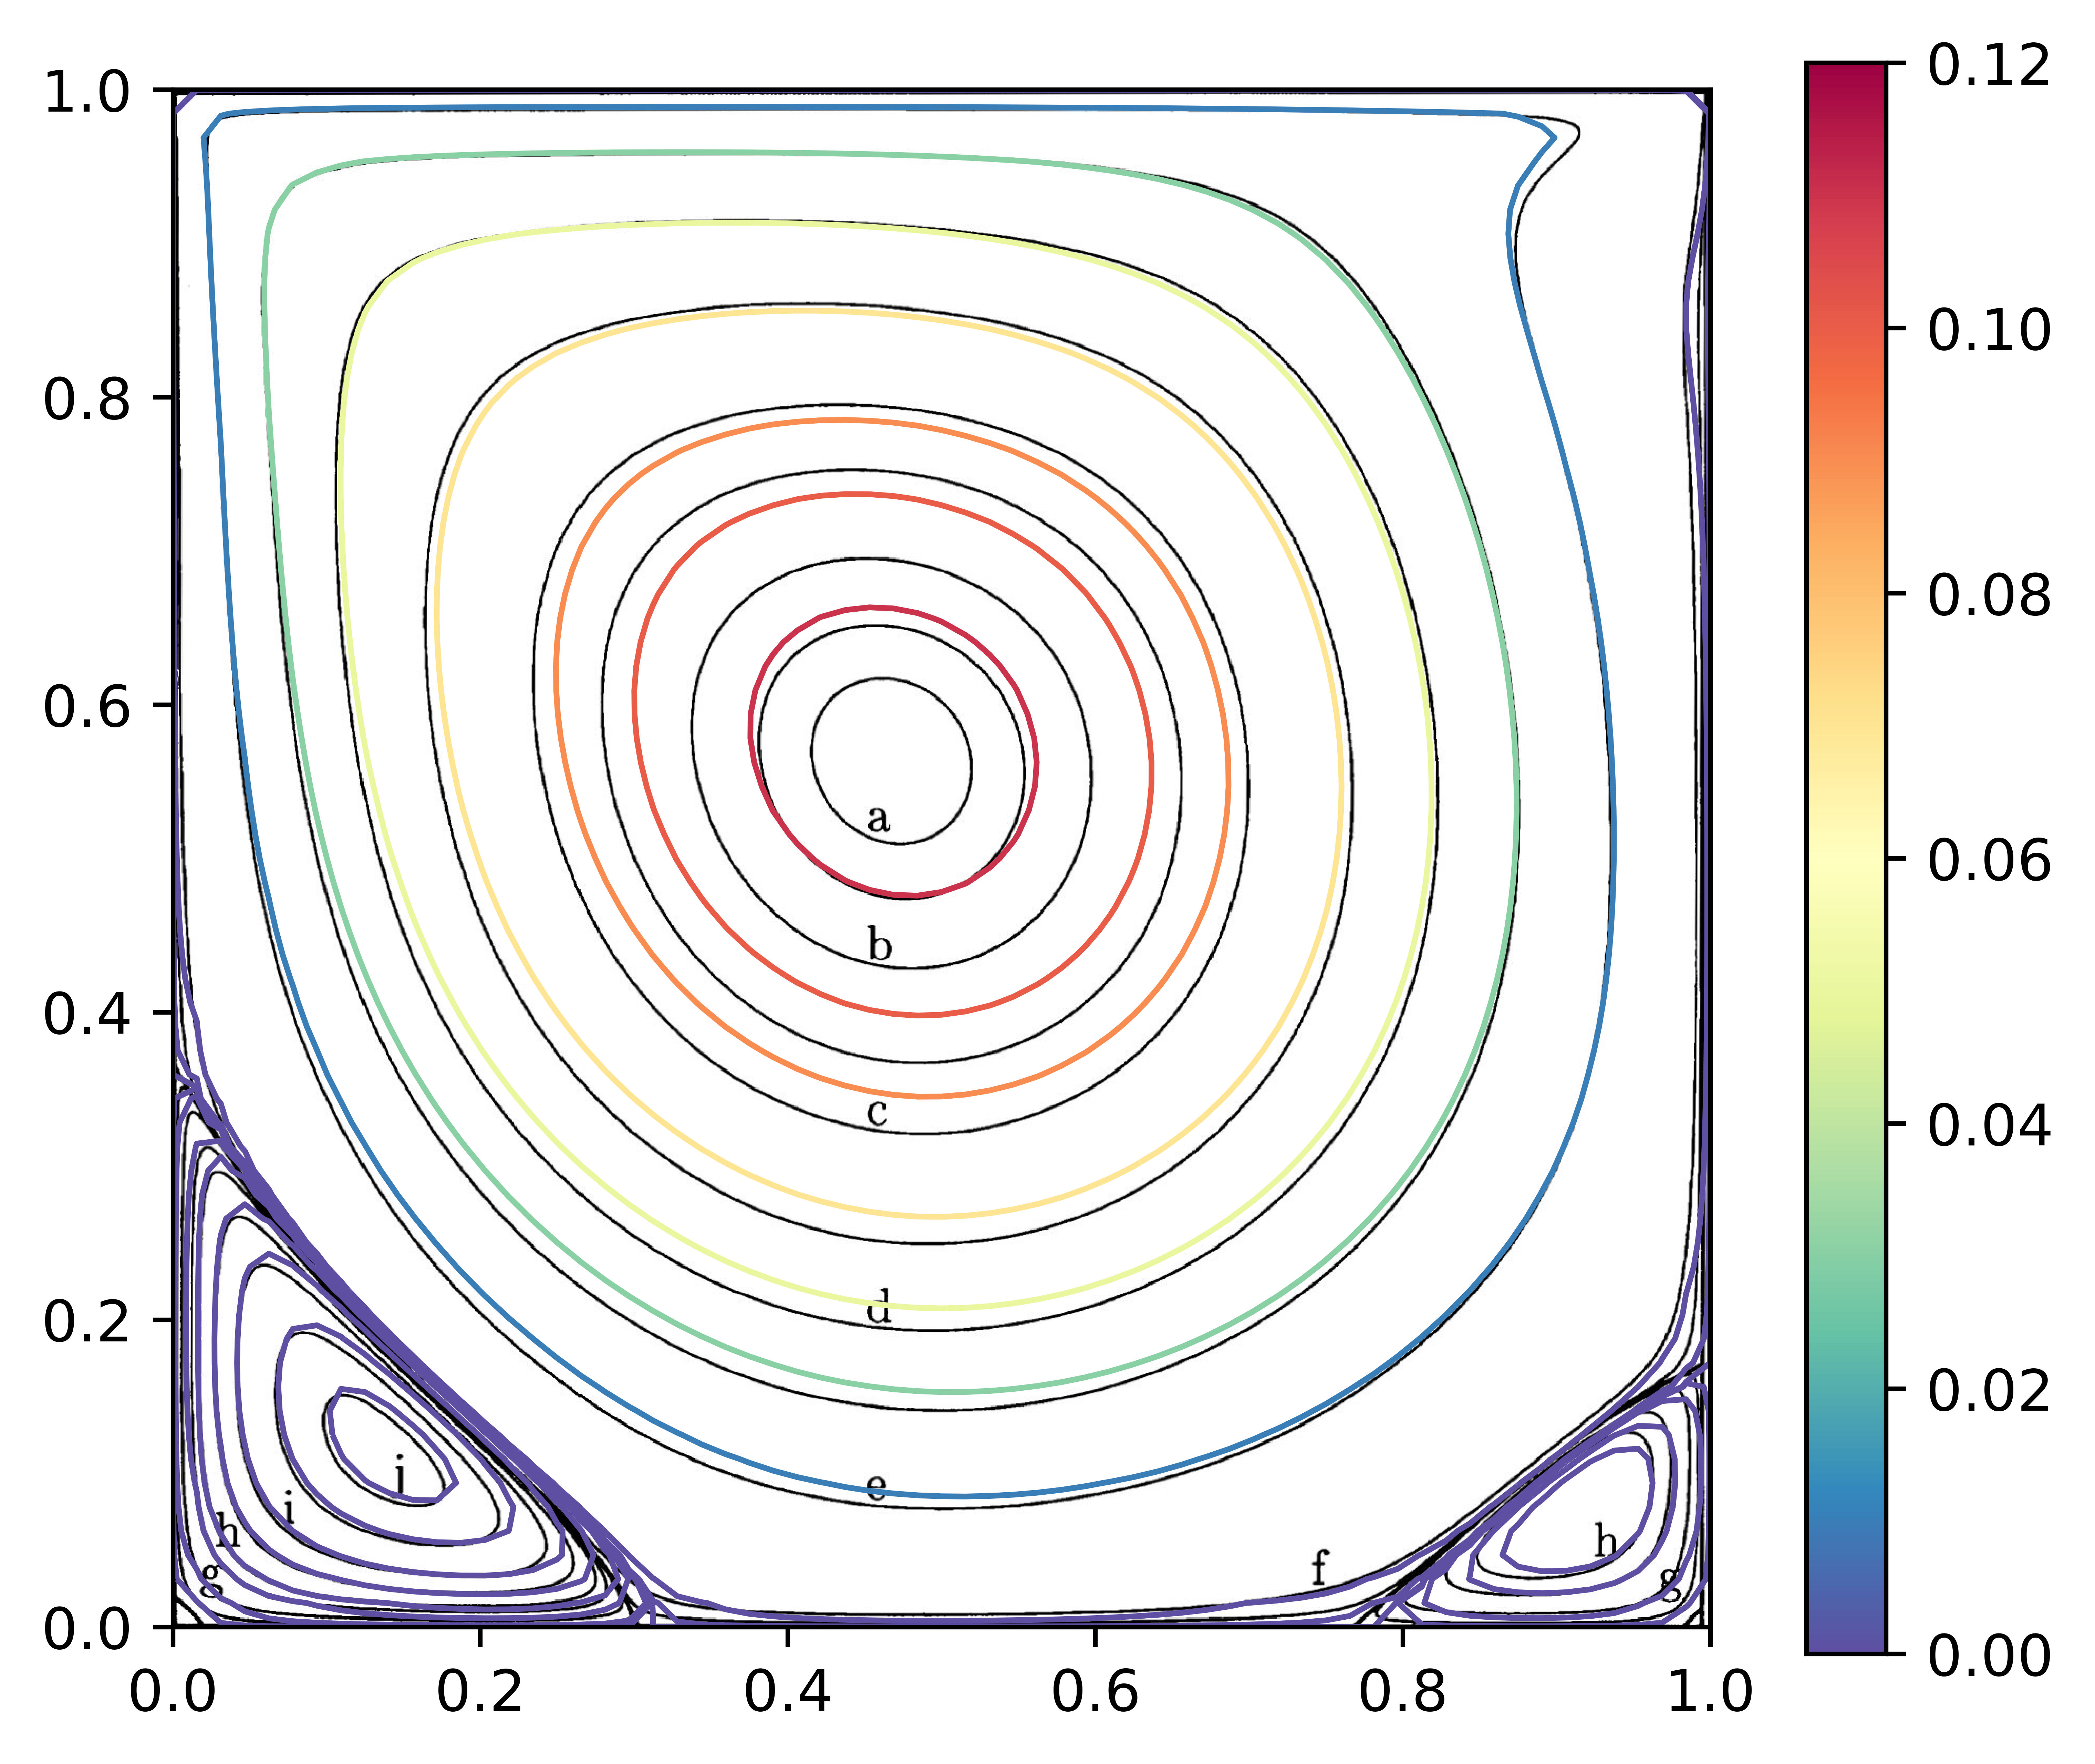

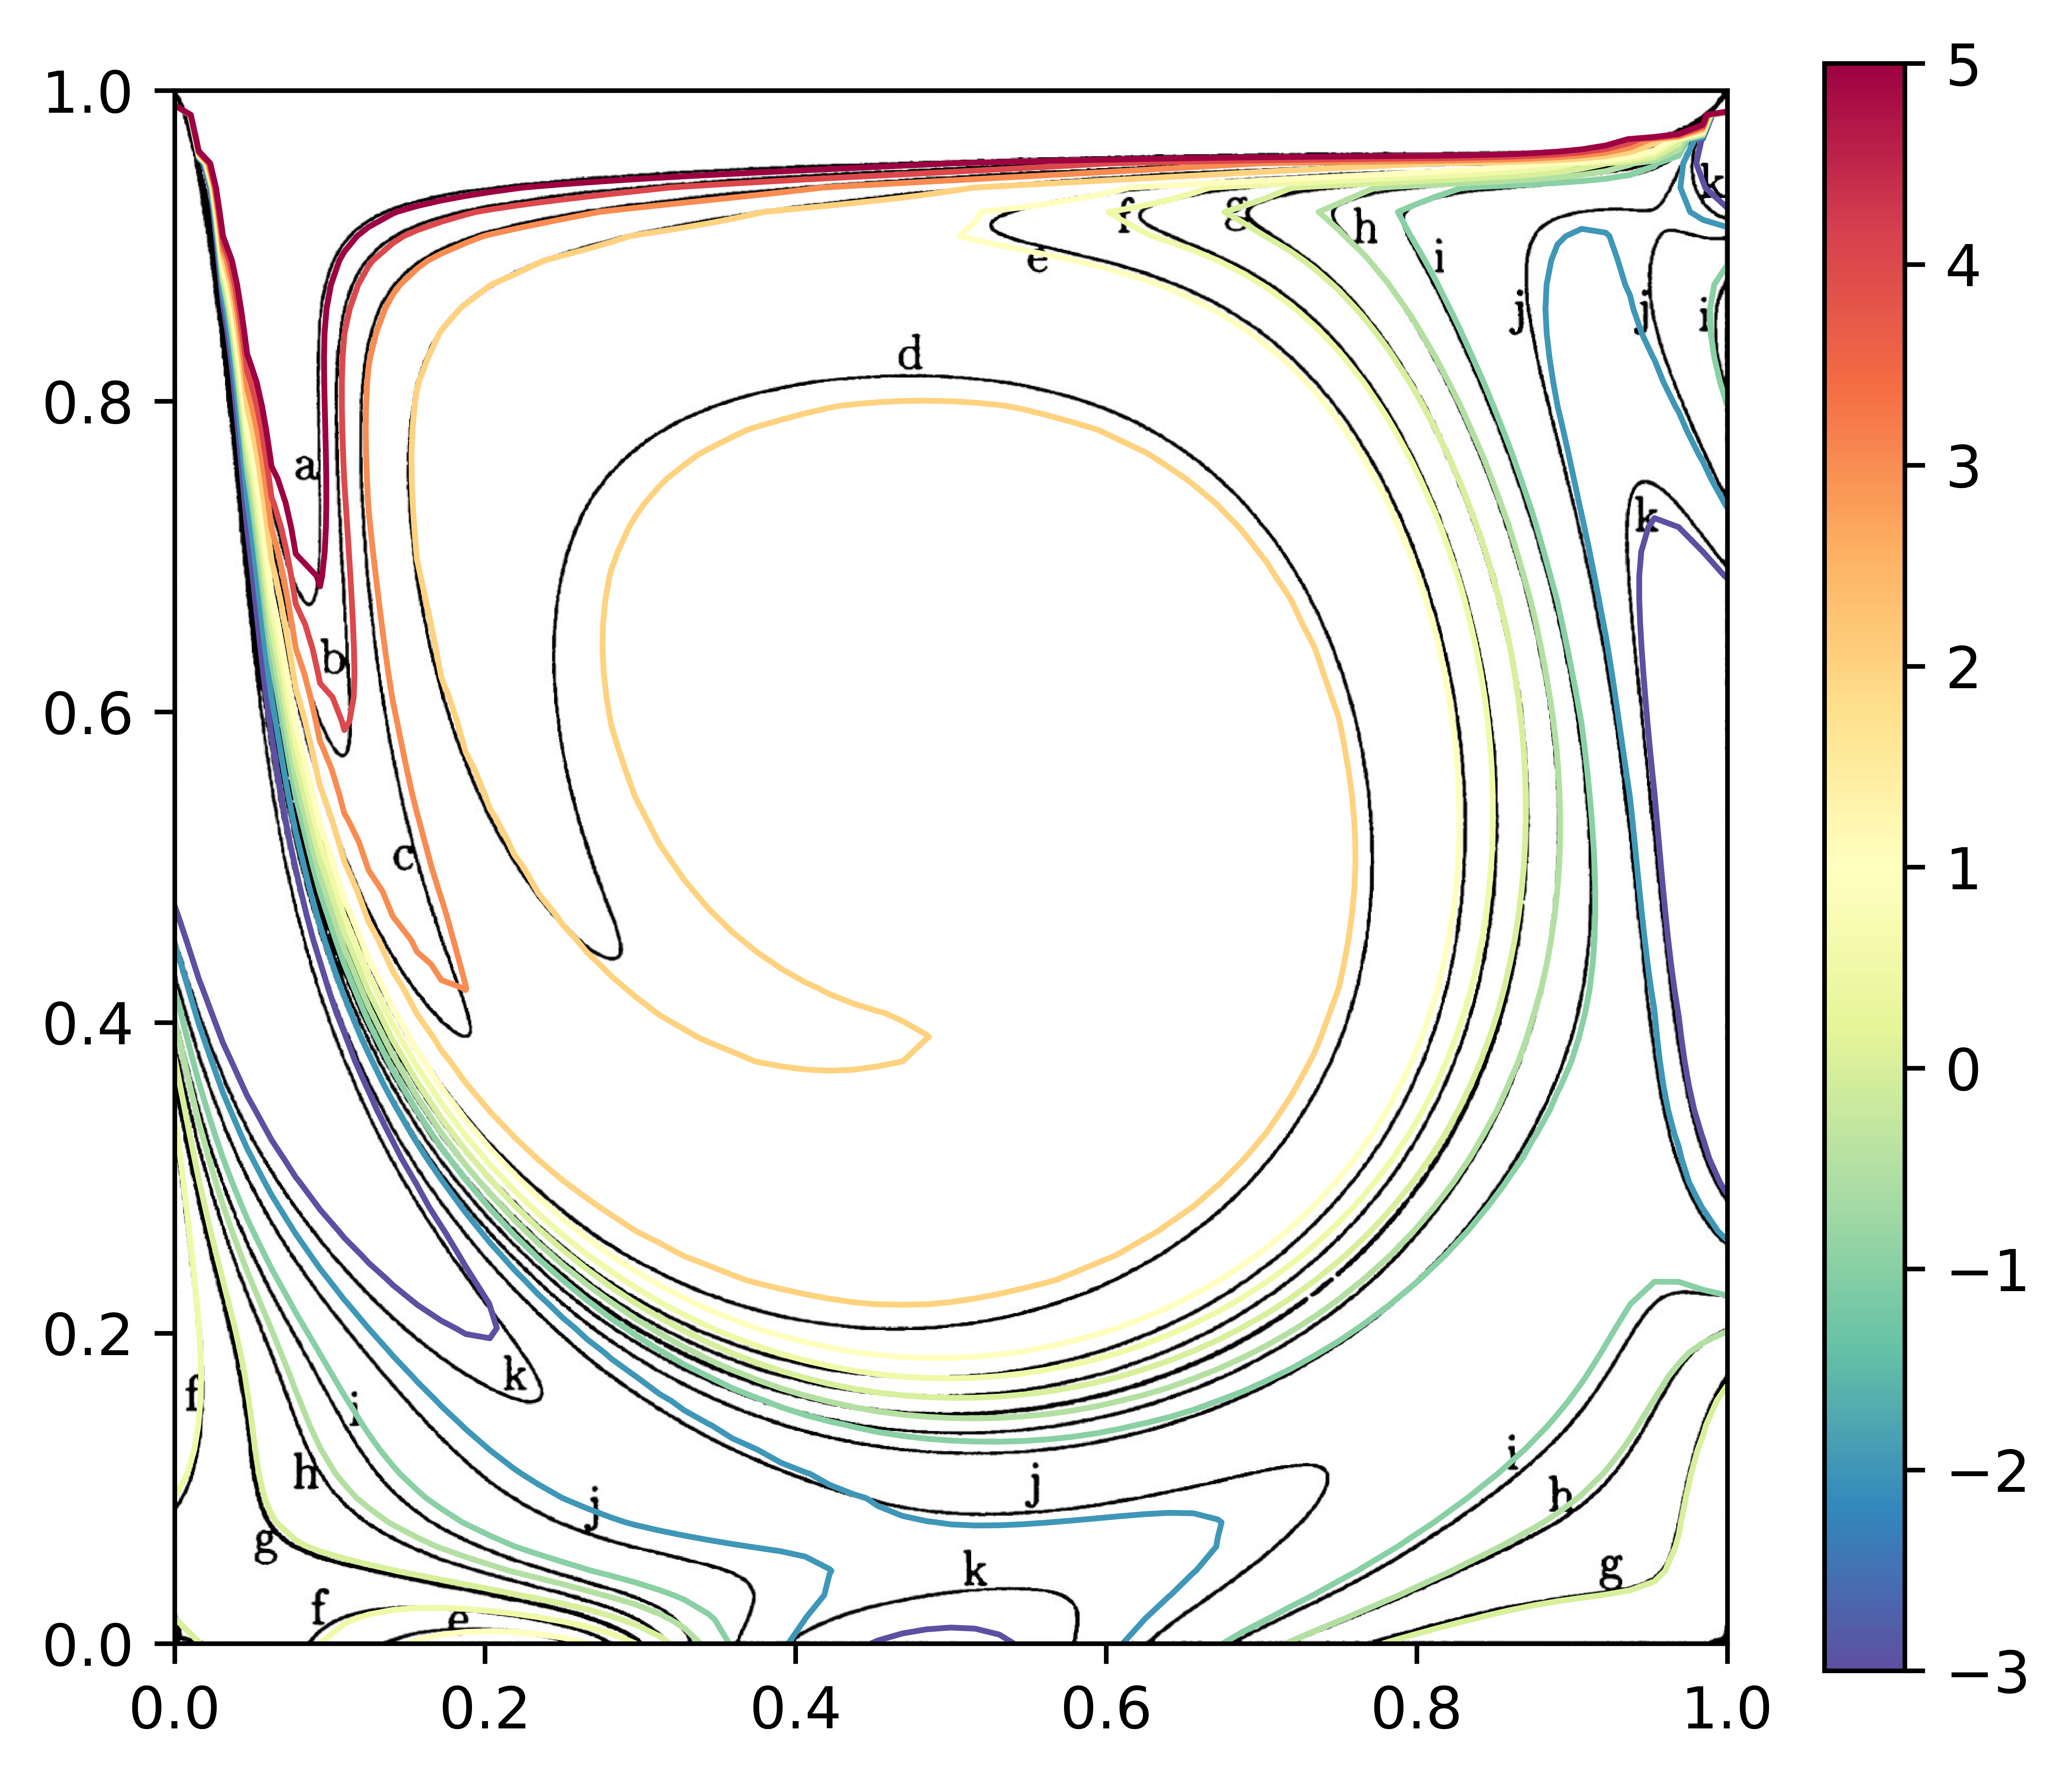

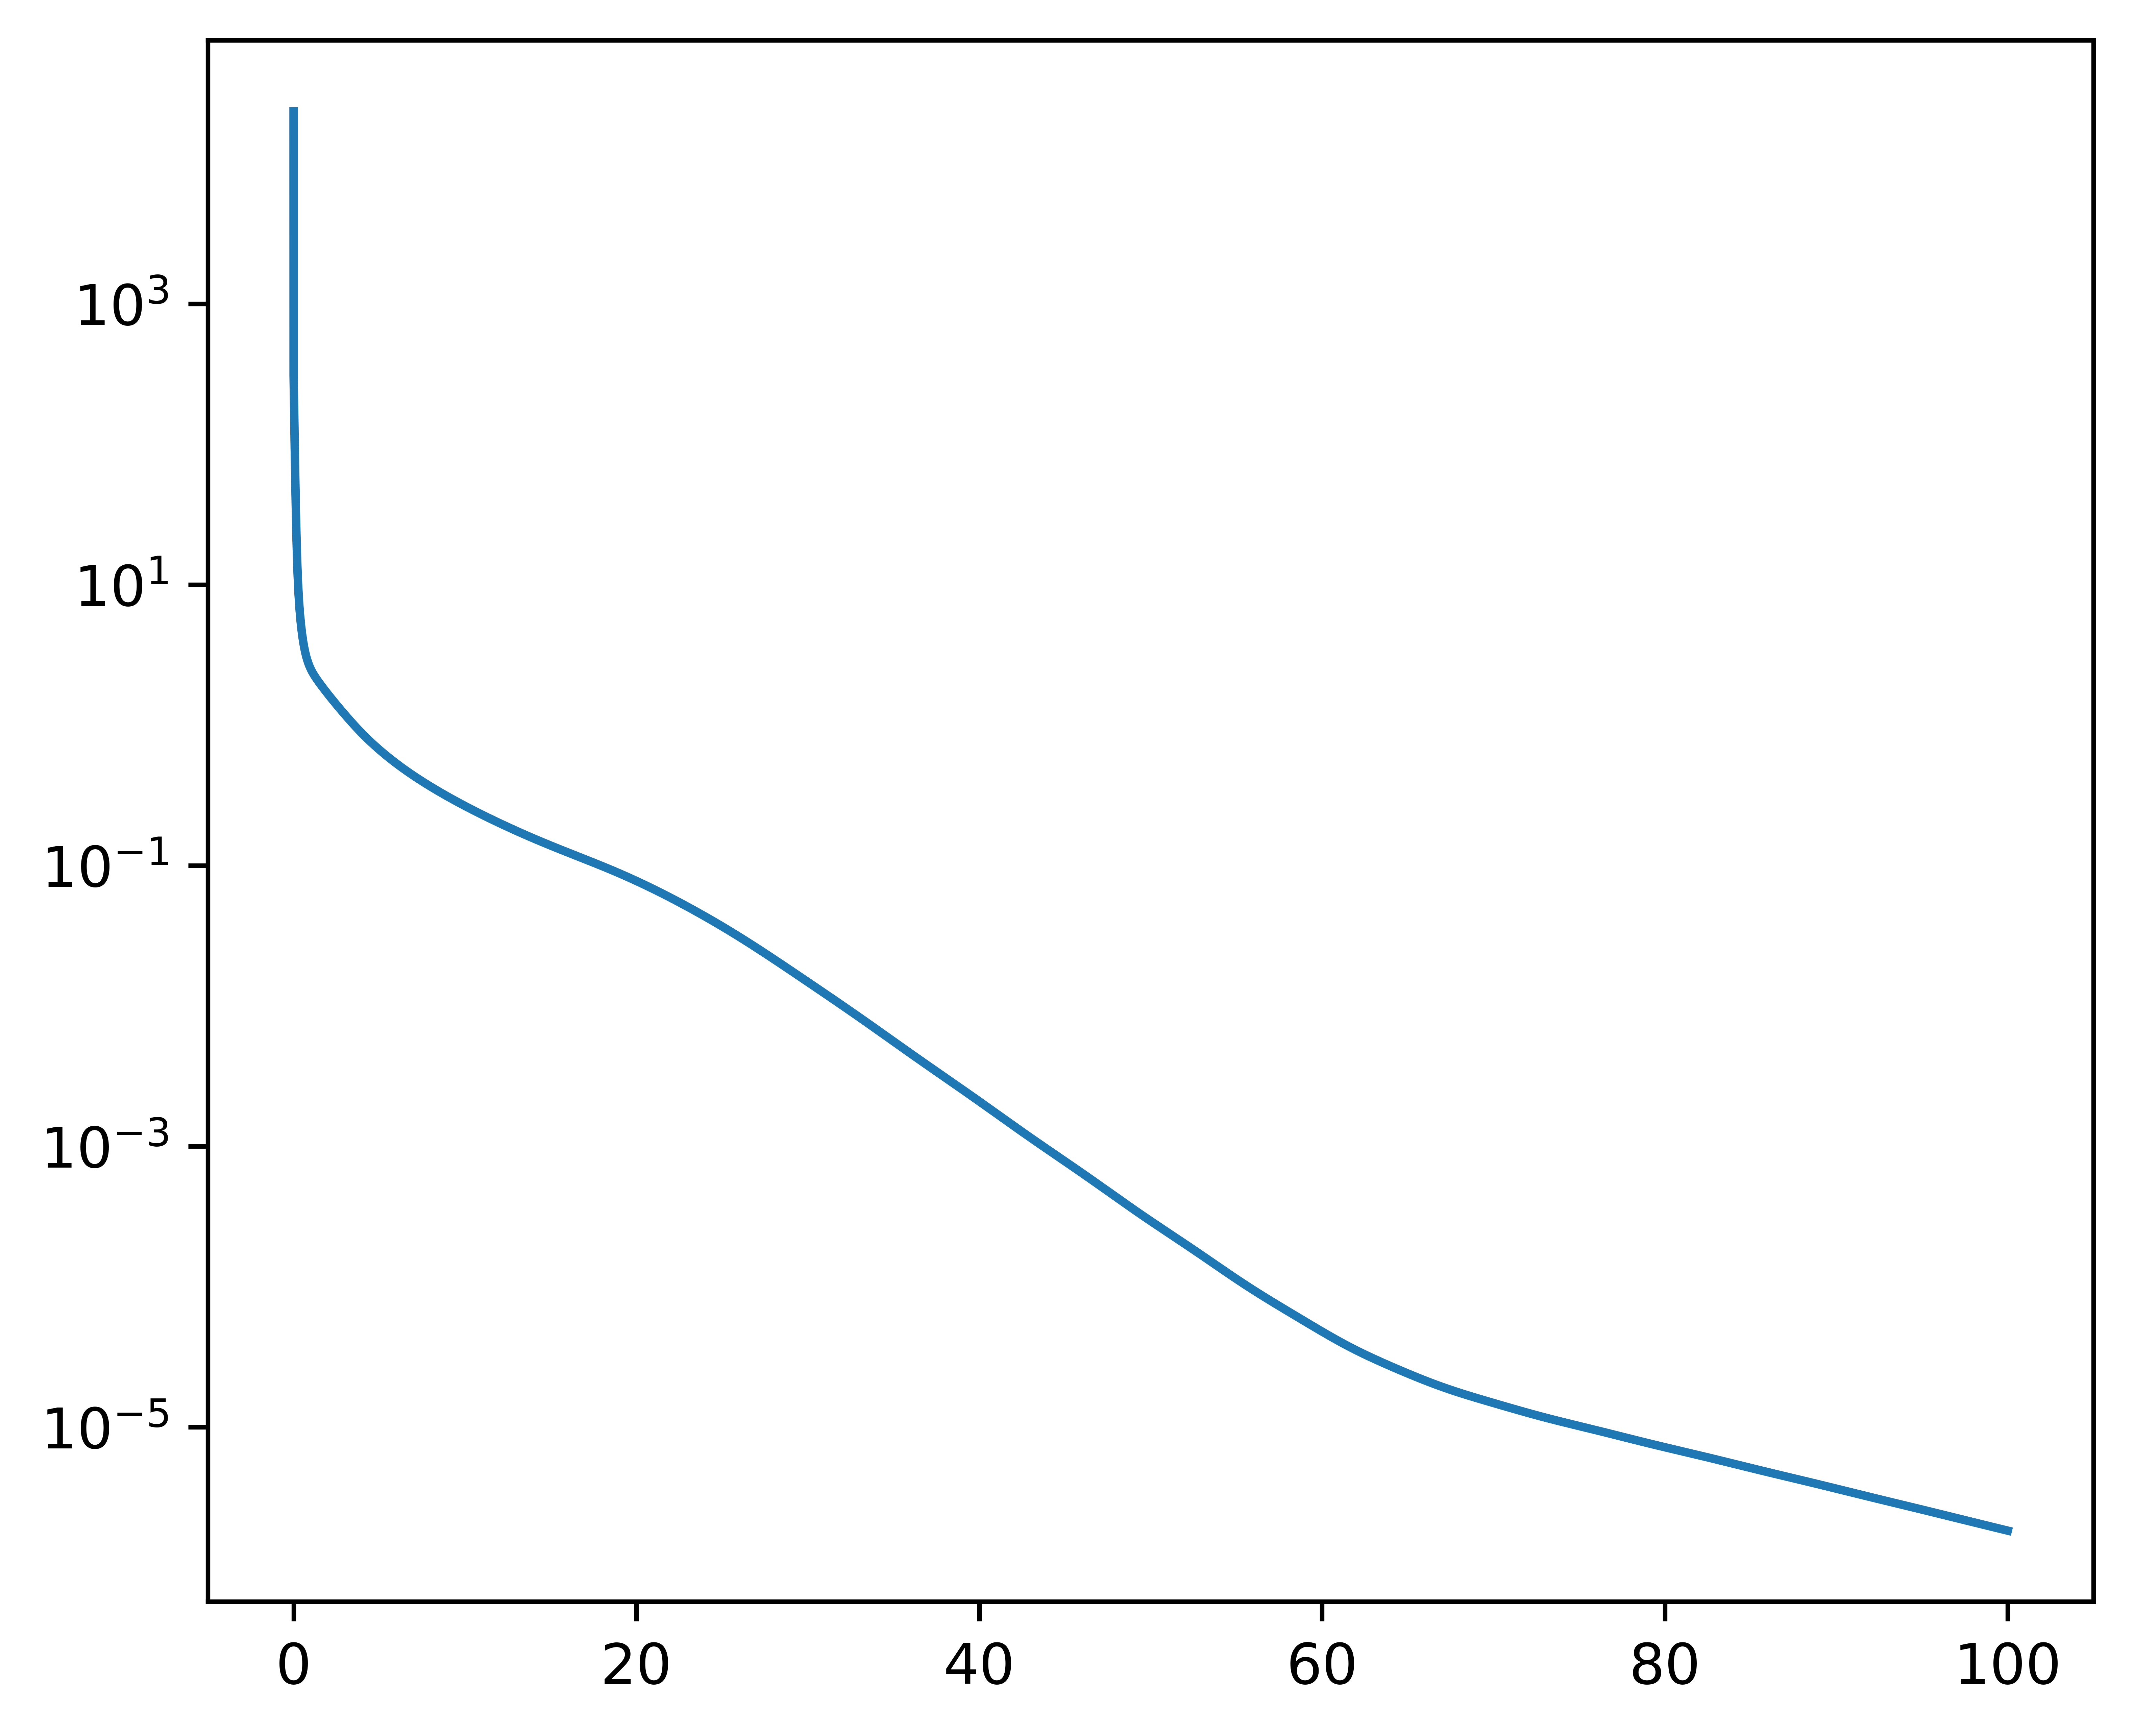

In [97]:
colormap = cm.get_cmap("Spectral_r")

imgS = mpimg.imread("expstream.jpeg")
normalize = mcolors.Normalize(vmin=0, vmax=0.12)
fig, ax = plt.subplots(figsize=(6, 5))
level = np.array([-1.5e-3, -1e-3, -5e-4, -2.5e-4, -1e-4, -5e-5, -1e-5, -1e-6,
                 0, 1e-10, 1e-5, 1e-4, 1e-2, 3e-2, 5e-2, 7e-2, 9e-2, 0.1, 0.11, 0.115, 0.1175])
ct = ax.contour(xMat, yMat, sOriginal, levels=level,
                cmap=colormap, norm=normalize, linewidths=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
cbar = fig.colorbar(s_map, ax=ax)

imgS = mpimg.imread("expvort.jpeg")
normalize = mcolors.Normalize(vmin=-3, vmax=5)
fig, ax = plt.subplots(figsize=(6, 5))
level = [-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 4, 5]
ct = ax.contour(xMat, yMat, wOriginal, levels=level,
                cmap=colormap, norm=normalize, linewidths=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
cbar = fig.colorbar(s_map, ax=ax)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(timeSeries[1:], dwdt)
ax.set_yscale("log")


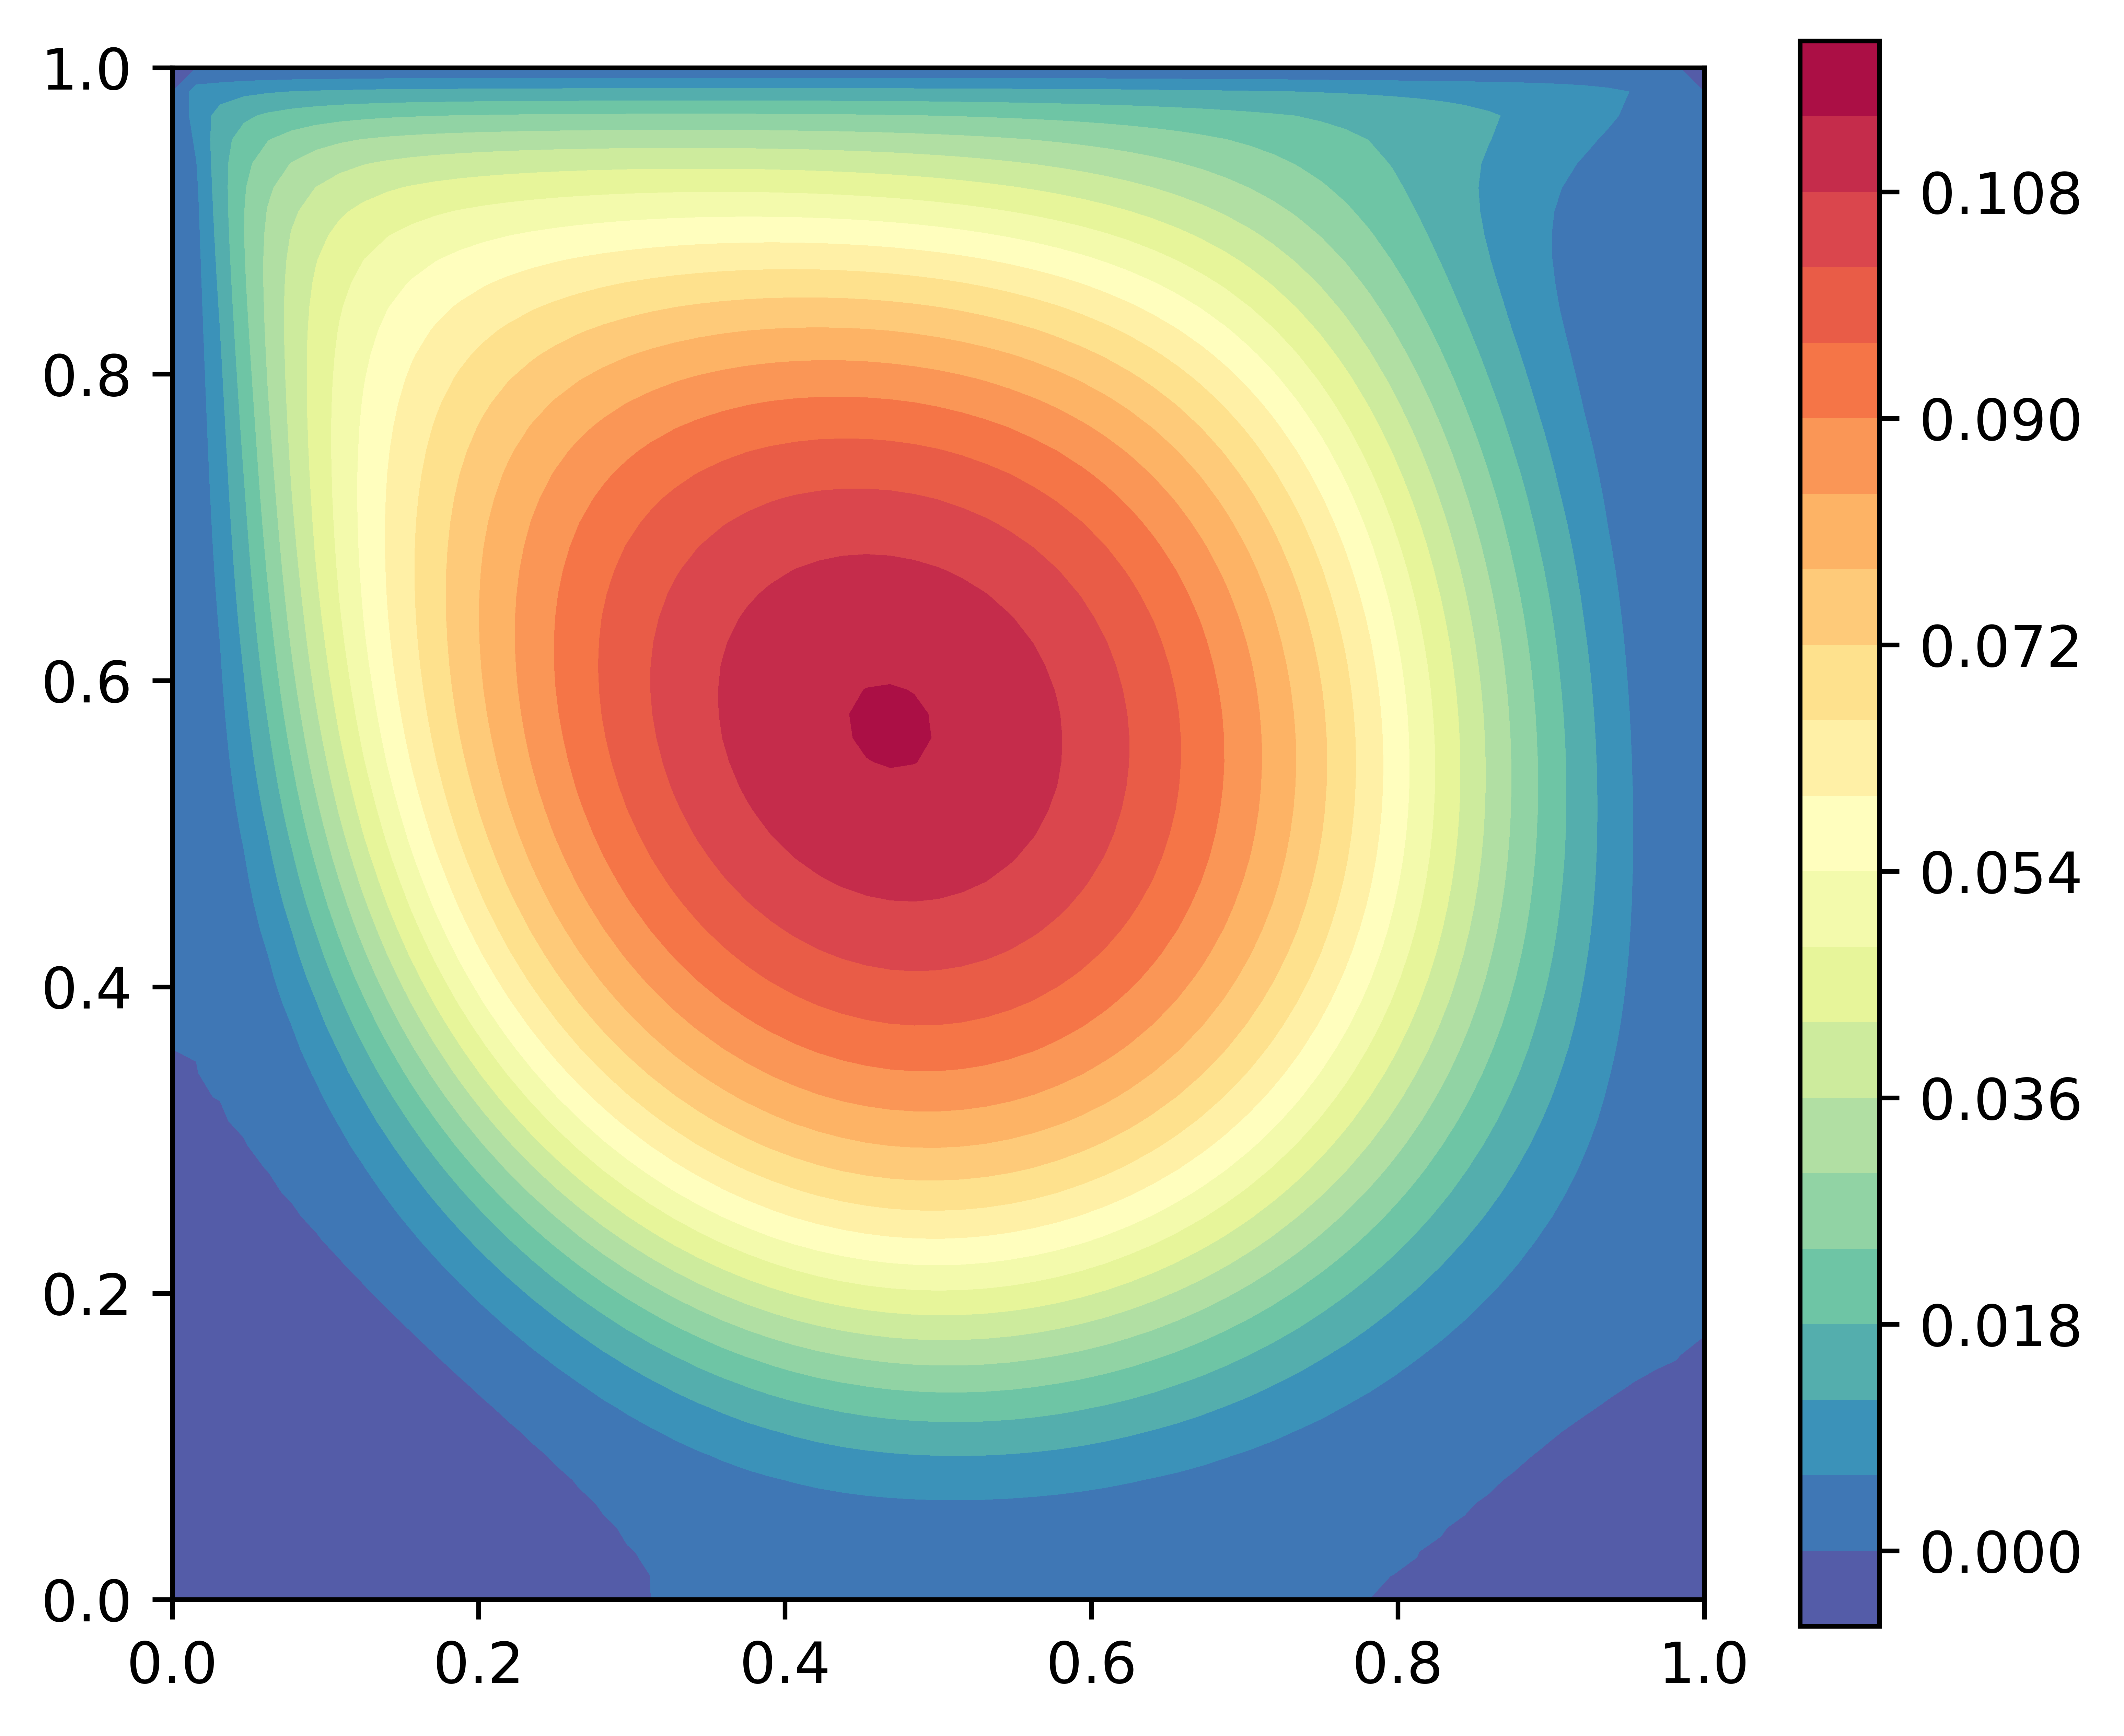

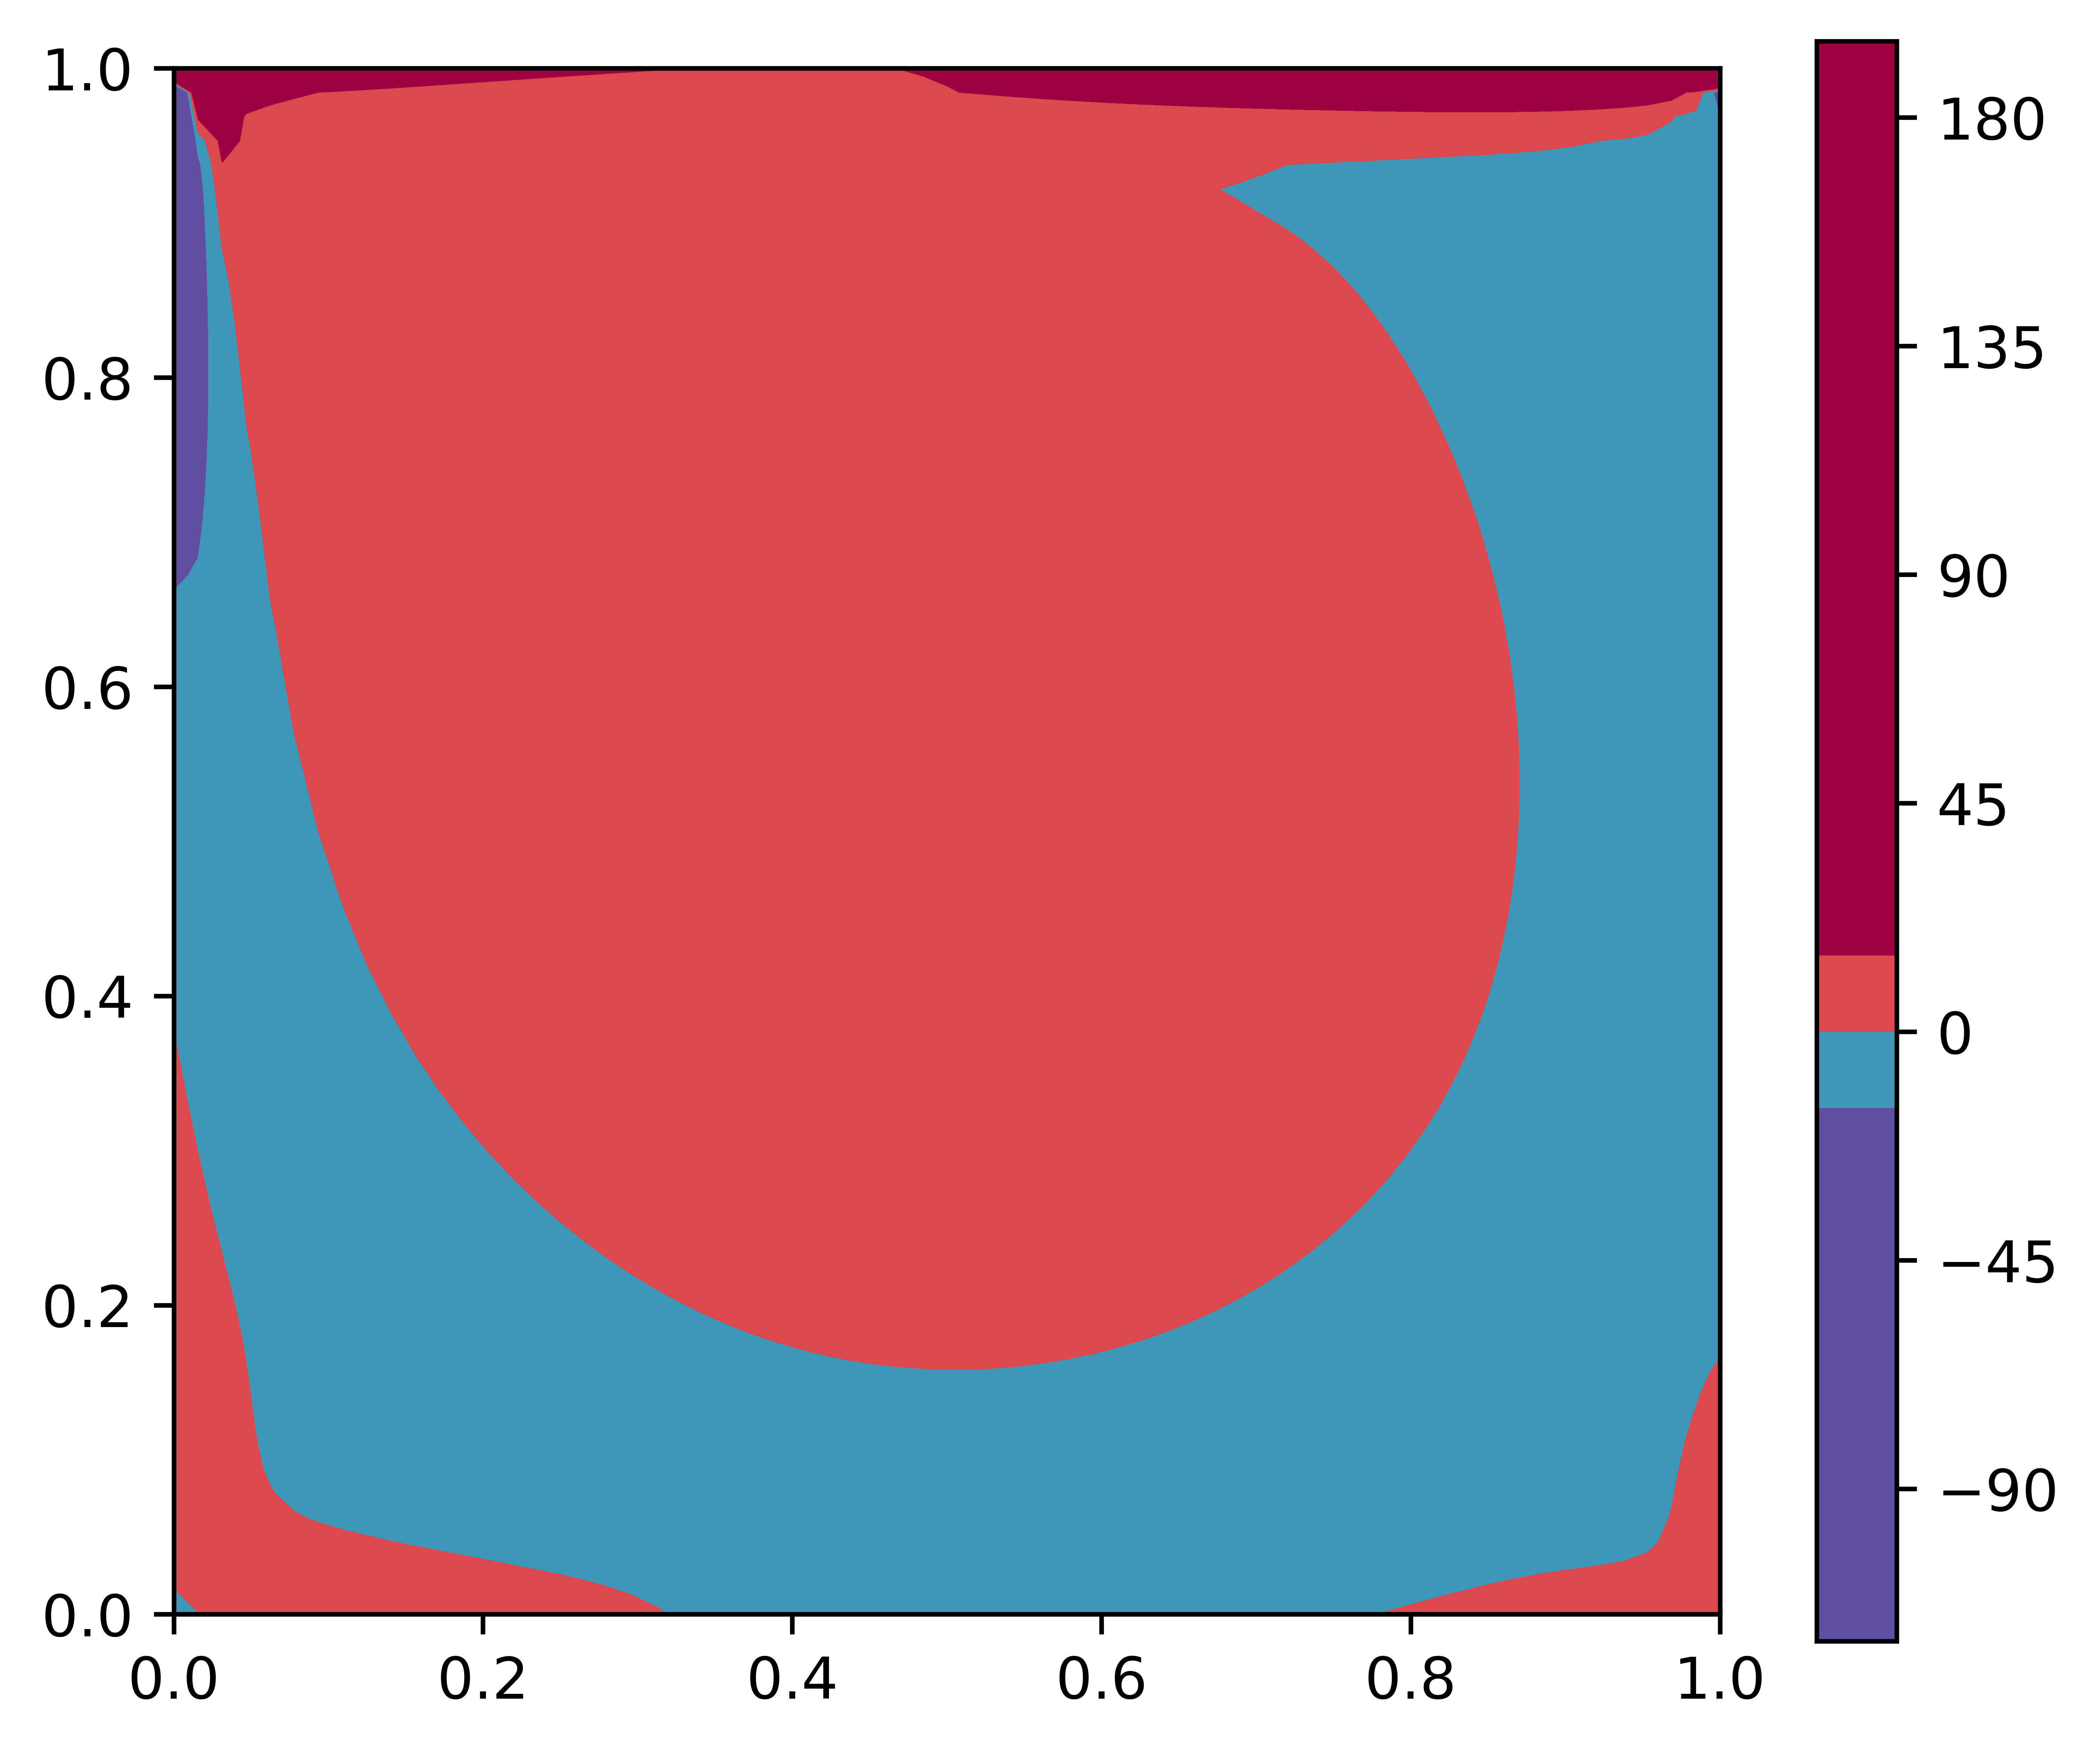

In [98]:
colormap = cm.get_cmap("Spectral_r")

imgS = mpimg.imread("expstream.jpeg")
fig, ax = plt.subplots(figsize=(6, 5))
a = ax.contourf(xMat, yMat, sOriginal, levels=20, cmap=colormap)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
cbar = fig.colorbar(a)

imgS = mpimg.imread("expvort.jpeg")
normalize = mcolors.Normalize(vmin=-10, vmax=10)
fig, ax = plt.subplots(figsize=(6, 5))
a = ax.contourf(xMat, yMat, wOriginal, levels=20,
                cmap=colormap, norm=normalize)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
cbar = fig.colorbar(a)


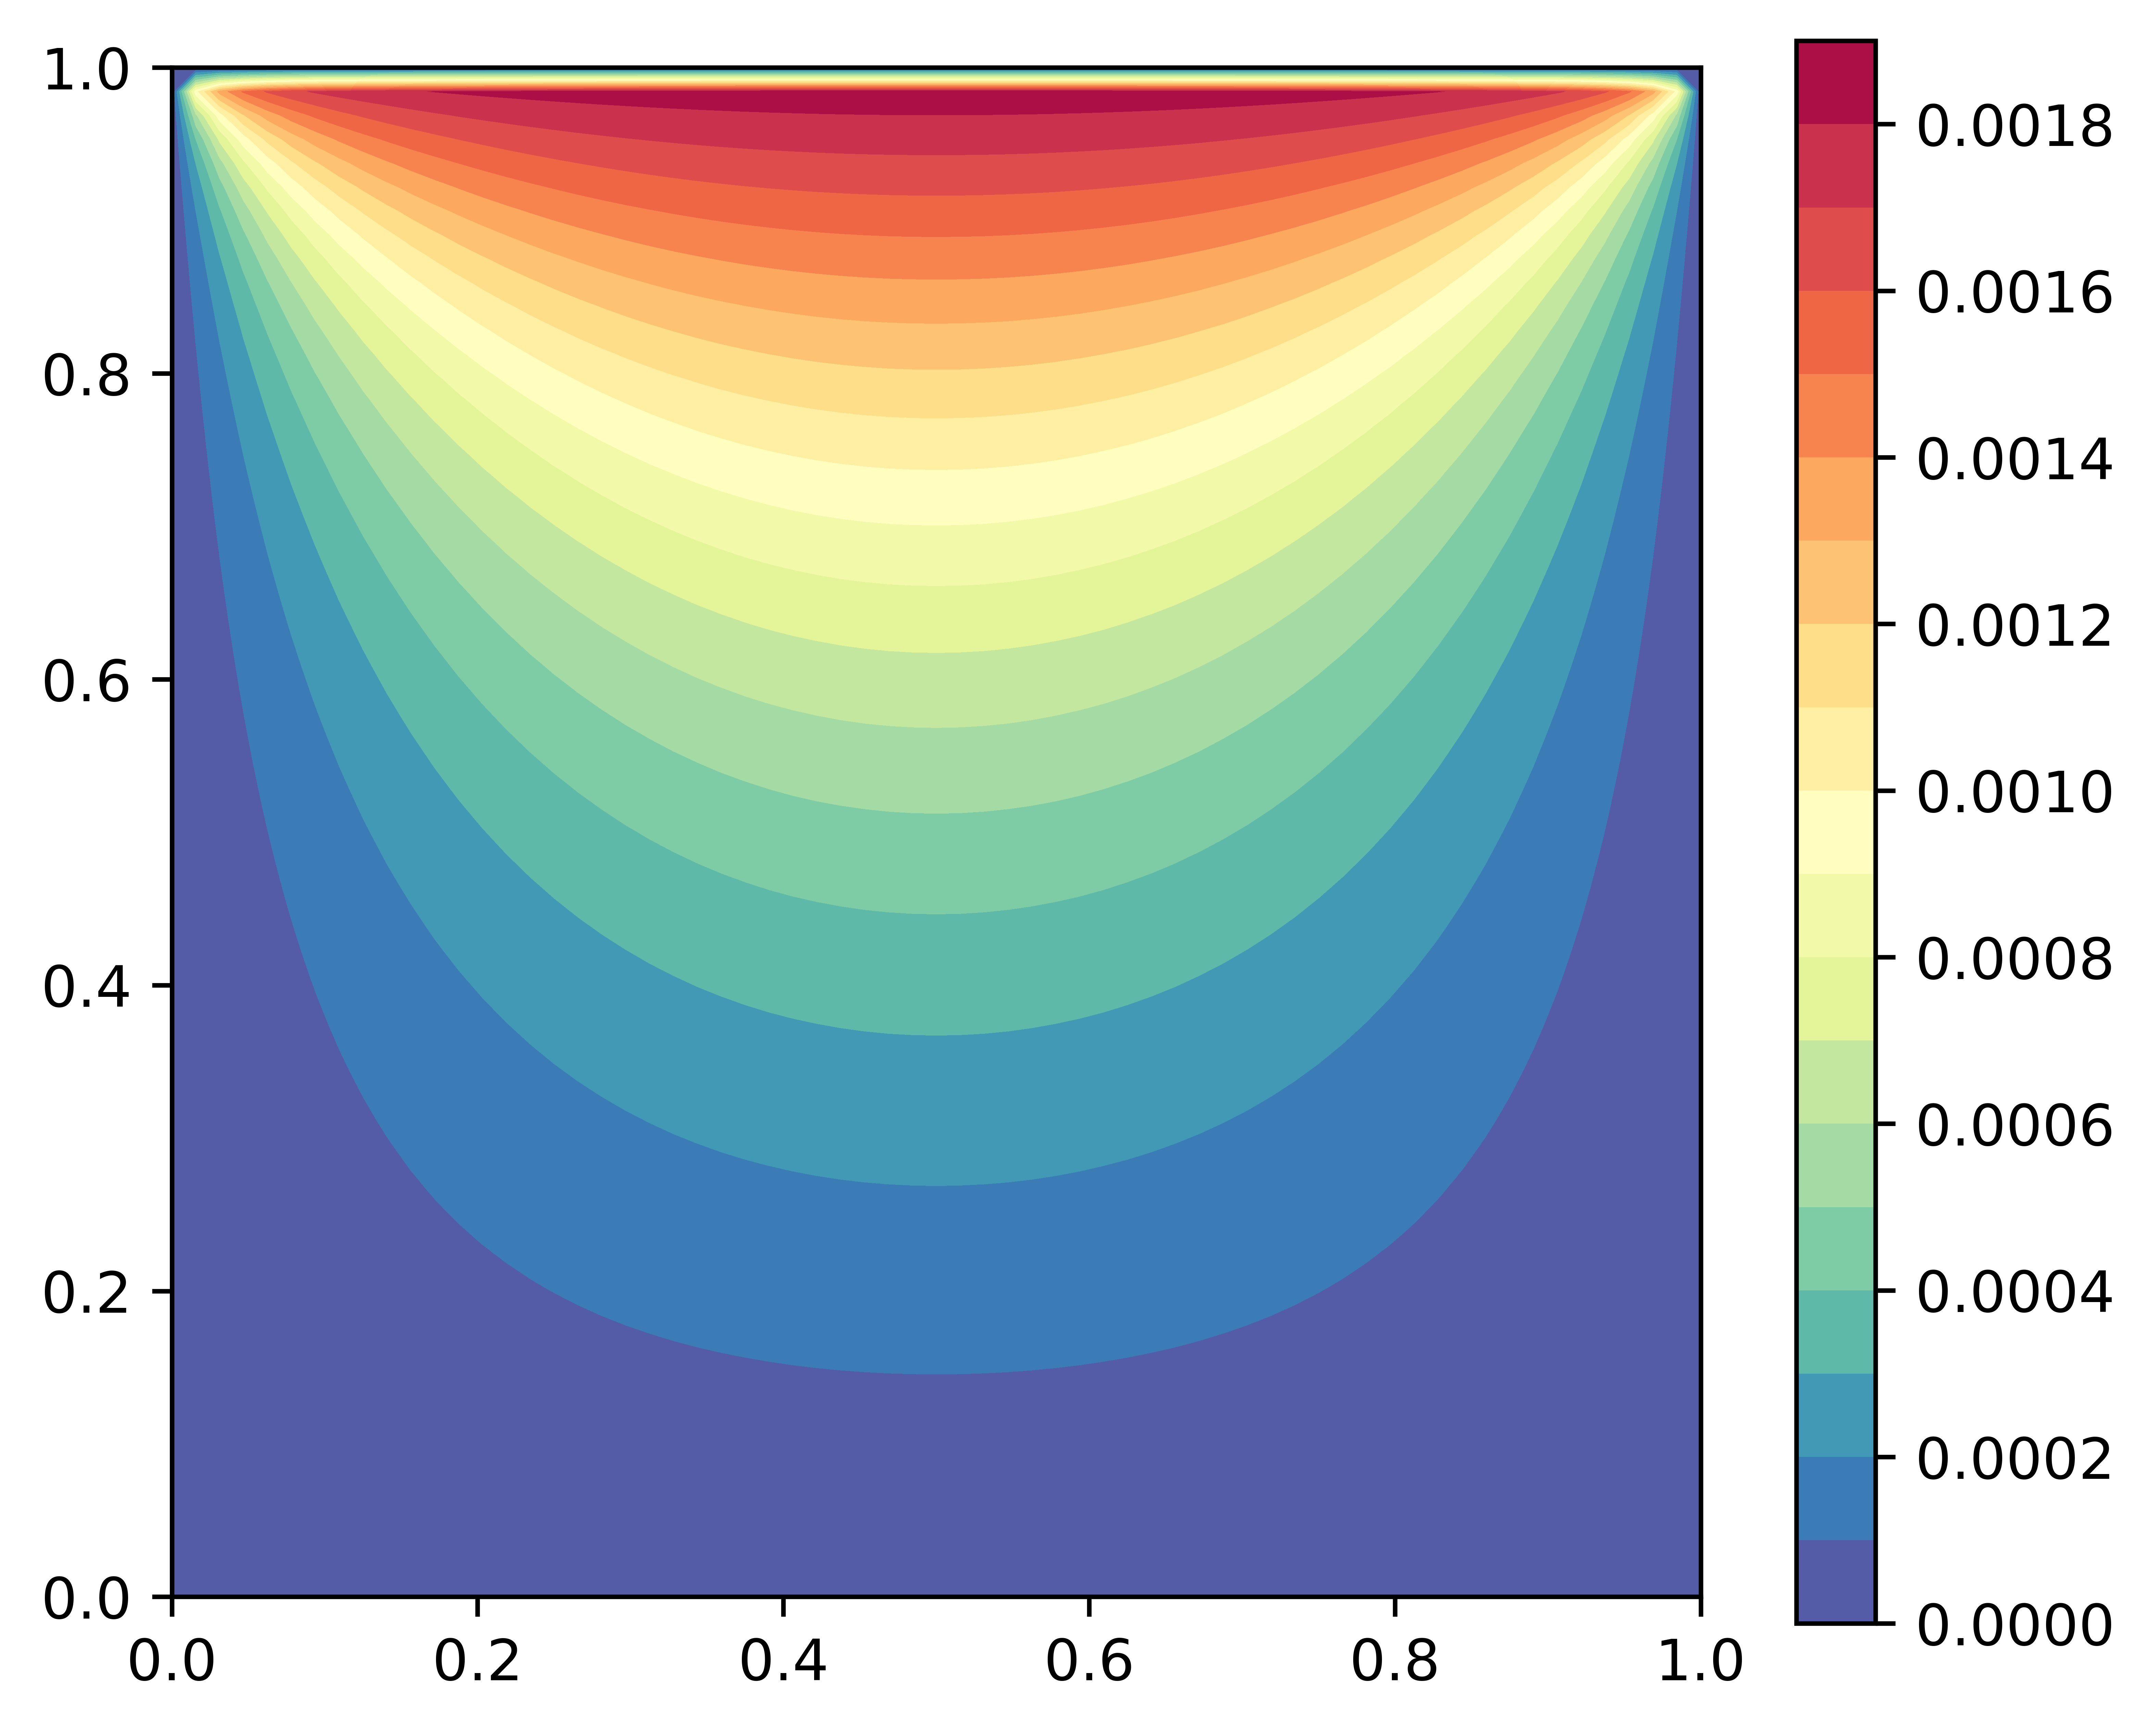

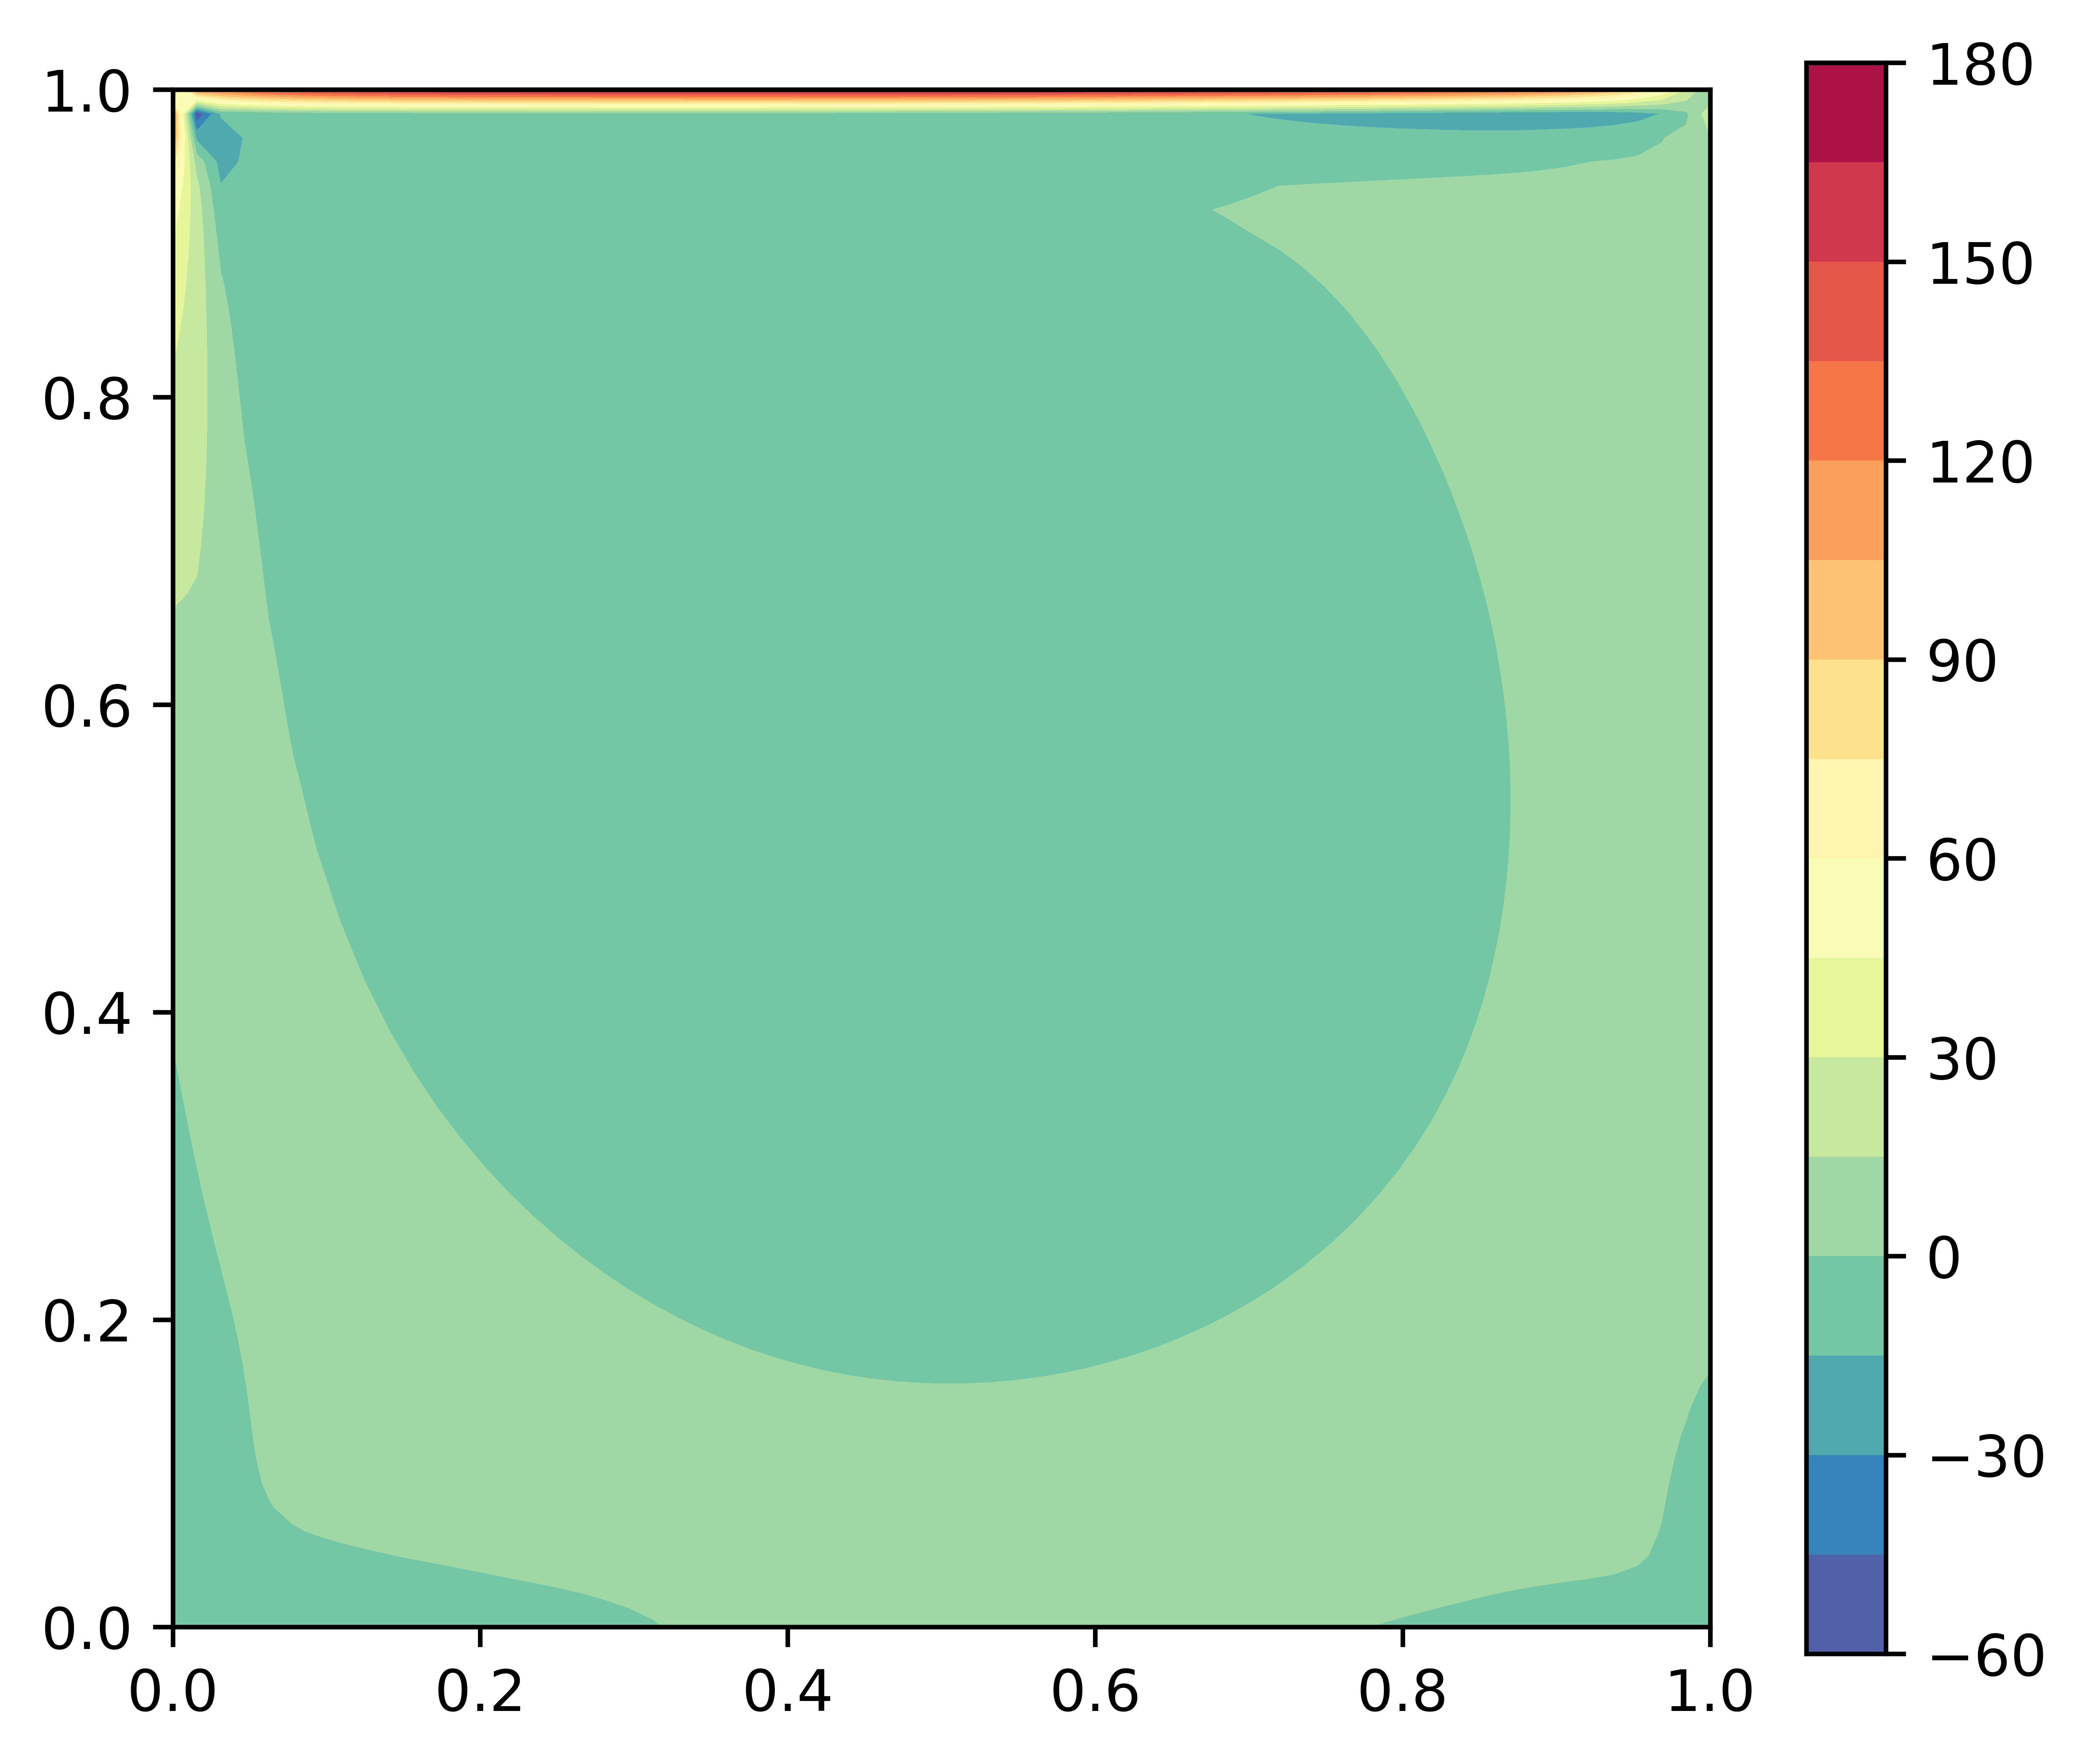

In [99]:
xyws = np.loadtxt("../field_final.txt")
xx = xyws[:,0].reshape(xMat.shape).T
yy = xyws[:,1].reshape(xMat.shape).T
ww = xyws[:,2].reshape(xMat.shape).T
ss = xyws[:,3].reshape(xMat.shape).T

colormap = cm.get_cmap("Spectral_r")

imgS = mpimg.imread("expstream.jpeg")
fig, ax = plt.subplots(figsize=(6, 5))
a = ax.contourf(xMat, yMat, ss, levels=20, cmap=colormap)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
cbar = fig.colorbar(a)

imgS = mpimg.imread("expvort.jpeg")
fig, ax = plt.subplots(figsize=(6, 5))
b = ax.contourf(xMat, yMat, ww-wOriginal, levels=20,
                cmap=colormap)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.imshow(imgS, aspect="auto", extent=[0, 1, 0, 1])
ax.set_aspect("equal")
cbar = fig.colorbar(b)

In [100]:
print(ww[:,-3])
print(wOriginal[:,-3])

print(ss[:,-2])
print(sOriginal[:,-2])
print(ss[:,-1]/sOriginal[:,-1])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-109.84148066   18.1016453    22.6032455    14.25540994   12.70421934   11.7966714    11.10034419   10.70347683   10.37012715   10.13950608    9.9462155     9.79881013    9.67588089    9.57852586    9.4988309     9.43632235    9.38779149    9.35260982    9.32931709    9.31736412    9.31593672    9.32453054    9.34253696    9.3694326     9.40463145    9.44754768    9.49754372    9.55395319    9.61606619    9.68314281    9.75441625    9.82910862    9.90644633    9.98568308   10.06612572   10.14716512   10.22830923   10.30921725   10.38973131   10.46990191   10.55000115   10.63051698   10.71211941   10.79558758   10.88168399   10.97095855   11.06346037   11.15832971   11.25323485   11.34361085   11.42164895   11.47498137   11.48501428   11.42490629   11.25732631   10.93247783   10.38767235    9

/var/folders/rm/jb3vm3c5061g59ks51w_tsr80000gn/T/ipykernel_29643/1429829466.py:6: RuntimeWarning: invalid value encountered in true_divide
  print(ss[:,-1]/sOriginal[:,-1])
